In [25]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import json
import pickle
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

In [2]:
'''
load images as gray images
'''
def read_image(path,ratio=1):
    img=cv.imread(path,0)
    dim=(int(img.shape[1]*ratio),int(img.shape[0]*ratio))
    resized=cv.resize(img,dim)
    return resized

In [9]:
'''
get feature matches
'''
def get_good_matches(descriptors,threshold=0.75):
    bf = cv.BFMatcher()  # Brute Force knn matcher
    n_images=len(descriptors)
    n_good_matches=np.zeros((n_images,n_images)) # store # of good matches between image_i and image_j
    good_matches=[[] for i in range(n_images)] # 2D list
    for i in range(n_images):
        for j in range(n_images):
            if(i!=j):
                des1,des2=descriptors[i],descriptors[j]  # des1——query index; des2 —— train index
                matches = bf.knnMatch(des1,des2,k=2)# find the best and second best match
                good = []
                for m,n in matches:
                    if m.distance < threshold*n.distance:
                        good.append(m)
                n_good_matches[i,j]=len(good)
                good_matches[i].append(good)
            else:
                good_matches[i].append([])
    
    return n_good_matches,good_matches

In [14]:
'''
linear triangulartion
'''
def linearTriangulation(P1,x1s,P2,x2s):
    '''
    Given two projection matrice and homogenous points, we triangulate them to get 3-D points
    '''
    XS=np.zeros((4,x1s.shape[0]))
    err=np.zeros((1,x1s.shape[0]))
    for k in range(x1s.shape[0]):
        r1=x1s[k,0]*P1[2,:]-P1[0,:]
        r2=x1s[k,1]*P1[2,:]-P1[1,:]
        r3=x2s[k,0]*P2[2,:]-P2[0,:]
        r4=x2s[k,1]*P2[2,:]-P2[1,:]
        
        A=np.vstack((r1,r2,r3,r4))
        U,S,Vh=np.linalg.svd(A)
        XS[:,k]=Vh.T[:,-1]/Vh.T[3,3]
        err[0,k]=S[-1]
    return XS,err

In [15]:
'''
decompose E
'''
def decomposeE(E,x1s,x2s):
    '''
    Given the essential and normalized homogenous points, 
    return the second projection matrix and the index of inliers
    '''
    W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    [U,S,Vh]=np.linalg.svd(E) # U and Vh is normalized
    
    # extract translation
    t=U[:,2].reshape((-1,1))
    
    # extraction rotation
    R1=np.dot(np.dot(U,W),Vh)
    R2=np.dot(np.dot(U,W.T),Vh)
    if(np.linalg.det(R1)<0):
        R1=-R1
    if(np.linalg.det(R2)<0):
        R2=-R2
    
    # four possible projection matrice
    P1=np.vstack((np.hstack((R1,t)),np.array([0,0,0,1])))
    P2=np.vstack((np.hstack((R1,-t)),np.array([0,0,0,1])))
    P3=np.vstack((np.hstack((R2,t)),np.array([0,0,0,1])))
    P4=np.vstack((np.hstack((R2,-t)),np.array([0,0,0,1])))
    Ps=[P1,P2,P3,P4]
    
    # determine the projection matrix by the maximum inliers
    n_inliers=[]
    ind_inliers=[]
    P=np.eye(4) # the first projection is identical
    for proj_mat in Ps:
        X,_=linearTriangulation(P,x1s,proj_mat,x2s)
        p1X=X
        p2X=np.dot(proj_mat,X)
        
        n_infront1=(p1X[2,:]>0).sum()
        n_infront2=(p2X[2,:]>0).sum()
        
        ind_valid=np.logical_and(p1X[2,:]>0,p2X[2,:]>0)
        ind_inliers.append(ind_valid)
        n_inliers.append(ind_valid.sum())
    
    # determine the best projection matrix by the most reconstructed points in front of the cameras
    n_inliers=np.array(n_inliers)
    ind_proj=n_inliers.argmax() 
    
    ind_inlier=ind_inliers[ind_proj]
    proj_mat=Ps[ind_proj]
    return proj_mat,ind_inlier

In [26]:
def proj_matrix_to_camera_vector(proj_mat):
    '''
    decompose the projection matrix to camera paras
    '''
    rot_mat=proj_mat[:3,:3]
    r=R.from_dcm(rot_mat)
    rot_vec=r.as_rotvec()
    t=proj_mat[:3,3]
    camera_vec=np.hstack((rot_vec,t))
    return camera_vec

In [18]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [19]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj=points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    return points_proj

In [20]:
# get residuals
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    '''
    get residuals
    '''
    # recover cameras params and points 3d
    camera_params=params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=params[n_cameras*6:].reshape((n_points,3))
    
    # reproject 3d points
    
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [22]:
# build sparse jacobian
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A

In [30]:
def recover_projection_matrix(camera_param):
    rot_vec=camera_param[:3]
    translate_vec=camera_param[3:]
    r=R.from_rotvec(rot_vec)
    rot_matrix=r.as_dcm()
    P=np.eye(4)
    P[:3,:3]=rot_matrix
    P[:3,3]=translate_vec.T
    return P

In [32]:
# get calibration matrix
path='matlab-code/data/k/K.txt'
f=open(path,'r')
lines=f.readlines()
K=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        K[i,j]=float(lines[i].split(' ')[j])
print(K)

[[2.75948e+03 0.00000e+00 1.52069e+03]
 [0.00000e+00 2.76416e+03 1.00681e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


In [33]:
# read all images
image_dir='./matlab-code/data/images/*.png'
files=glob.glob(image_dir)
print('%d images founded' % len(files))

images=[]
for eachimage in files:
    img=read_image(eachimage)
    images.append(img)
print(images[0].shape)

11 images founded
(2048, 3072)


In [34]:
# use SURF to get features
keypoints,descriptors=[],[]
surf = cv.xfeatures2d.SURF_create(hessianThreshold=400,extended=True)
for image in images:
    kp, des = surf.detectAndCompute(image,None)
    keypoints.append(kp)
    descriptors.append(des)

In [35]:
# get feature matches
%time n_good_matches, good_matches=get_good_matches(descriptors)

CPU times: user 10min 2s, sys: 1.51 s, total: 10min 3s
Wall time: 2min 52s


In [36]:
# determine initial pair
ind = np.unravel_index(np.argmax(n_good_matches, axis=None), n_good_matches.shape)
ind_img1,ind_img2=ind[0],ind[1]
print(ind_img1,ind_img2)

0 2


In [37]:
# reconstruct from first pair
img1,img2=images[ind_img1],images[ind_img2]
good_match=good_matches[ind_img1][ind_img2]

# recover 2D pts
pts1,pts2=[],[]
for ele in good_match:
    pts1.append(keypoints[ind_img1][ele.queryIdx].pt)
    pts2.append(keypoints[ind_img2][ele.trainIdx].pt)
pts1=np.int32(pts1)
pts2=np.int32(pts2)

# compute F
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

# filter the outliers 
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# calibrate the homogeneous points
if(pts1.shape[1]==2):
    pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
if(pts2.shape[1]==2):
    pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
img1_calibrated_inliers=np.dot(np.linalg.inv(K),pts1.T).T
img2_calibrated_inliers=np.dot(np.linalg.inv(K),pts2.T).T
print(img1_calibrated_inliers.shape,img2_calibrated_inliers.shape)

# get Essential matrix from calibration matrix and fundamental matrix
E=np.dot(np.dot(K.T,F),K)

projection_matrix, ind_inliers=decomposeE(E,img1_calibrated_inliers,img2_calibrated_inliers)
print('# pairs: %d' % img1_calibrated_inliers.shape[0])
print('# Reconstructed inliers: %d' % ind_inliers.sum())

(2247, 3) (2247, 3)
# pairs: 2247
# Reconstructed inliers: 2247


In [38]:
# bundle adjustment
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,P2,inliers2)

(2, 6)
(2247, 3)
(4494,)
(4494,)
(4494, 2)


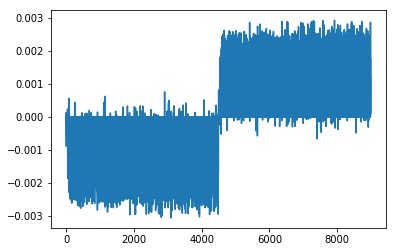

In [39]:
n_cameras=2
n_points=XS.shape[1]

# get camera params,  n_cameras x 6
camera_params=np.zeros((n_cameras,6))
camera_params[0,:]=proj_matrix_to_camera_vector(P1)
camera_params[1,:]=proj_matrix_to_camera_vector(P2)
print(camera_params.shape)

# points_3d, n_points x 3
points_3d=XS[:3,:].T
print(points_3d.shape)

# get camera_indice

camera_indices=[]
for i in range(n_cameras):
    camera_indices.extend([i]*n_points)
camera_indices=np.array(camera_indices)
print(camera_indices.shape)

# get points_ind
point_indices=[]
for i in range(n_cameras):
    for j in range(n_points):
        point_indices.append(j)
point_indices=np.array(point_indices)
print(point_indices.shape)

# get point_2d
pts_2d_1=inliers1[:,:2]
pts_2d_2=inliers2[:,:2]
pts_2d=np.vstack((pts_2d_1,pts_2d_2))
print(pts_2d.shape)

# get params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, pts_2d)
plt.plot(f0)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5741e-03                                    3.25e+00    
       1              2         3.8008e-05      5.54e-03       4.10e+00       4.62e-02    
       2              3         3.4653e-05      3.35e-06       9.16e-02       1.01e-04    
       3              4         3.4653e-05      2.76e-11       1.61e-04       1.67e-06    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 5.5741e-03, final cost 3.4653e-05, first-order optimality 1.67e-06.


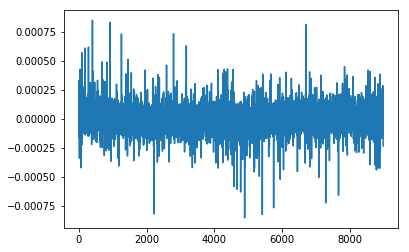

In [40]:
# optimize
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
t0 = time.time()
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, pts_2d))
t1 = time.time()
plt.plot(res.fun)

In [41]:
optimized_params=res.x
# get new camera_paras
camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
P1=recover_projection_matrix(camera_params[0])
P2=recover_projection_matrix(camera_params[1])

# get new pts_3d
points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))

In [49]:
# x,y,z=XS[0,:], XS[1,:], XS[2,:]
# fig = go.Figure(data=[go.Scatter3d(x=x, 
#                                    y=y, 
#                                    z=z,
#                                    mode='markers',
#                                    marker=dict(
#                                        size=2))])
# fig.show()

In [48]:
# # get new pts_3d
# x,y,z=points_3d[:,0], points_3d[:,1],points_3d[:,2]
# fig = go.Figure(data=[go.Scatter3d(x=x, 
#                                    y=y, 
#                                    z=z,
#                                    mode='markers',
#                                    marker=dict(
#                                        size=2))])
# fig.update_layout(width=800,height=800)
# fig.show()

In [45]:
# initial query and train indice
query_indice=[ele.queryIdx for ele in good_match] # img1
train_indice=[ele.trainIdx for ele in good_match] # img2

# filter by ransacFundamental and decomposeE
query_indice=np.array(query_indice)
train_indice=np.array(train_indice)

mask_F=mask.ravel()==1
mask_E=ind_inliers
query_indice=query_indice[mask_F][mask_E]
train_indice=train_indice[mask_F][mask_E]

In [46]:
# find next image with most overlapping 2D pts
img1_matches=good_matches[ind_img1]
n_overlaps=[]
ind_overlaps=[]
for match in img1_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
    ind_overlaps.append(ind_overlap)
n_overlaps=np.array(n_overlaps)
print(n_overlaps)

[   0  945 2247  726   48   76  133  334  160  129  304]


In [47]:
# find next image with most overlapping 2D pts
img2_matches=good_matches[ind_img2]
n_overlaps=[]
ind_overlaps=[]
for match in img2_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
    ind_overlaps.append(ind_overlap)
n_overlaps=np.array(n_overlaps)
print(n_overlaps)

[696 316   0 663  28  61 107 343 178  53 102]
